In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import torch

In [12]:
# fetch dataset
student_performance = fetch_ucirepo(id=320)

# data (as pandas dataframes)
X = student_performance.data.features
y = student_performance.data.targets

print(student_performance.metadata)

allData = pd.concat([X, y], axis=1)
print(allData.columns)
allData

{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'published_in': 'Proceedings of 5th Annual Future Business Technology Conference', 'year'

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


# Clustering
## K-Means + PCA

Selected 11 numerical columns: ['age', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


/home/ashmitchamoli/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/ashmitchamoli/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ashmitchamoli/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/ashmitchamoli/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

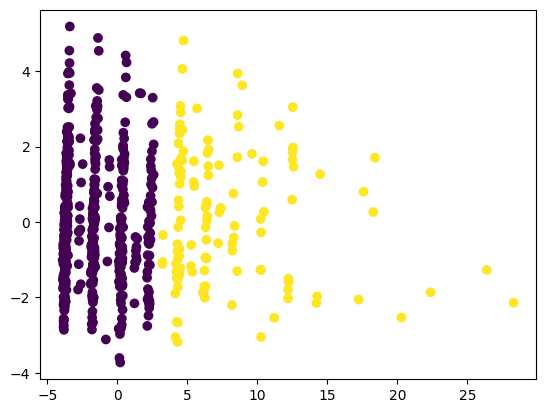

In [4]:
numericalColumns = X.select_dtypes(exclude=['object', 'bool']).columns
numericalColumns = list(numericalColumns)
numericalColumns.remove('Medu')
numericalColumns.remove('Fedu')
print(f"Selected {len(numericalColumns)} numerical columns: {numericalColumns}")

# k-means
numClusters = 2
kmeans = KMeans(n_clusters=numClusters, init='k-means++')
kmeans.fit(X[numericalColumns])

# use PCA to reduce dimensions to 2
pca = PCA(n_components=2).fit(X[numericalColumns])
datapoint = pca.transform(X[numericalColumns])

# plot
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=kmeans.labels_)
plt.show()

## Auto-Encoders

In [5]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, inputSize : int, embeddingSize : int, intermediateLayers : list[int]) -> None:
        super().__init__()
        self.inputSize = inputSize
        self.embeddingSize = embeddingSize
        self.intermediateLayers = intermediateLayers
        self.encoder = torch.nn.Sequential()
        self.decoder = torch.nn.Sequential()
        
        if (len(intermediateLayers) == 0):
            self.encoder.add_module(f"encoder_0", torch.nn.Linear(self.inputSize, self.embeddingSize))
            self.decoder.add_module(f"decoder_0", torch.nn.Linear(self.embeddingSize, self.inputSize))
            return

        # encoder
        self.encoder.add_module(f"encoder_0", torch.nn.Linear(self.inputSize, self.intermediateLayers[0]))
        self.encoder.add_module(f"encoder_activation_0", torch.nn.ReLU())
        for i in range(1, len(self.intermediateLayers)):
            self.encoder.add_module(f"encoder_{i}", torch.nn.Linear(self.intermediateLayers[i-1], self.intermediateLayers[i]))
            self.encoder.add_module(f"encoder_activation_{i}", torch.nn.ReLU())
        self.encoder.add_module(f"encoder_{len(self.intermediateLayers)}", torch.nn.Linear(self.intermediateLayers[-1], self.embeddingSize))

        # decoder
        self.decoder.add_module(f"decoder_0", torch.nn.Linear(self.embeddingSize, self.intermediateLayers[0]))
        self.decoder.add_module(f"decoder_activation_0", torch.nn.ReLU())
        for i in range(1, len(self.intermediateLayers)):
            self.decoder.add_module(f"decoder_{i}", torch.nn.Linear(self.intermediateLayers[i-1], self.intermediateLayers[i]))
            self.decoder.add_module(f"decoder_activation_{i}", torch.nn.ReLU())
        self.decoder.add_module(f"decoder_{len(self.intermediateLayers)}", torch.nn.Linear(self.intermediateLayers[-1], self.inputSize))
        
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        h = x
        x = self.decoder(x)
        return x, h

/home/ashmitchamoli/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 0: 24.359011
Epoch 10: 2.638133
Epoch 20: 2.630283
Epoch 30: 2.612035
Epoch 40: 2.567634
Epoch 50: 1.122481
Epoch 60: 1.034751
Epoch 70: 1.012383
Epoch 80: 1.000856
Epoch 90: 0.993941
Epoch 100: 0.989429
Epoch 110: 0.986064
Epoch 120: 0.983082
Epoch 130: 0.979882
Epoch 140: 0.976466
Epoch 150: 0.973765
Epoch 160: 0.970616
Epoch 170: 0.968784
Epoch 180: 0.967319
Epoch 190: 0.966758
Epoch 200: 0.960875
Epoch 210: 0.958031
Epoch 220: 0.955666
Epoch 230: 0.953324
Epoch 240: 0.950690
Epoch 250: 0.949318
Epoch 260: 0.948072
Epoch 270: 0.945964
Epoch 280: 0.944802
Epoch 290: 0.941380


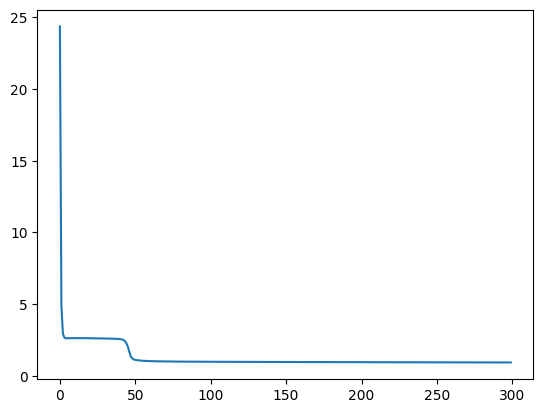

In [6]:
numericalColumns = X.select_dtypes(exclude=['object', 'bool']).columns
numericalColumns = list(numericalColumns)
model = AutoEncoder(len(numericalColumns), 2, [16, 8])
epochs = 300
lr = 0.006
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

trainLoss = []
for epoch in range(epochs):
    # divide into batches
    runningLoss = 0
    for i in range(0, len(X[numericalColumns]), 32):
        optimizer.zero_grad()
        output, _ = model(torch.tensor(X[numericalColumns].iloc[i:i+32].values, dtype=torch.float))
        loss = criterion(output, torch.tensor(X[numericalColumns].iloc[i:i+32].values, dtype=torch.float))
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    trainLoss.append(runningLoss / (len(X[numericalColumns]) / 32))
    if (epoch % 10 == 0):
        print(f"Epoch {epoch}: {trainLoss[-1]:3f}")

# plot
plt.plot(trainLoss)
plt.show()

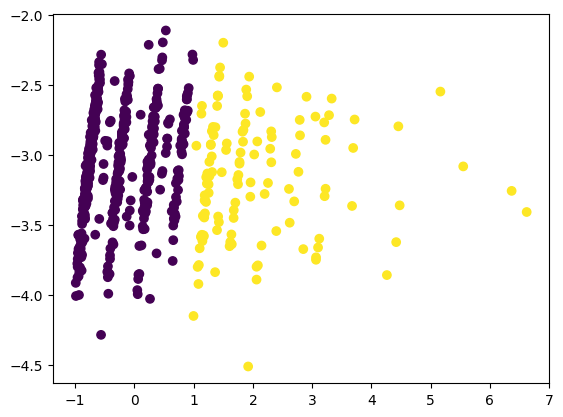

In [7]:
with torch.no_grad():
    embeddings = model.encoder(torch.tensor(X[numericalColumns].values, dtype=torch.float)).detach().numpy()
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=kmeans.labels_)
plt.show()

The clustering suggests the exisitence of special groups.

In [8]:
# print the average score of each student cluster
X['cluster'] = kmeans.labels_
X['G3'] = y['G3']
groupsWiseStats = X[numericalColumns + ['G3', 'cluster']].groupby('cluster').mean()
groupsWiseStats

/tmp/ipykernel_1077990/2840868812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = kmeans.labels_
/tmp/ipykernel_1077990/2840868812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['G3'] = y['G3']


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G3
cluster,,,,,,,,,,,,,,
0,16.647059,2.527514,2.311195,1.569260,1.965844,0.189753,3.979127,3.184061,3.113852,1.417457,2.176471,3.552182,1.857685,12.055028
1,17.163934,2.459016,2.286885,1.565574,1.778689,0.360656,3.721311,3.163934,3.491803,1.868852,2.729508,3.467213,11.442623,11.262295


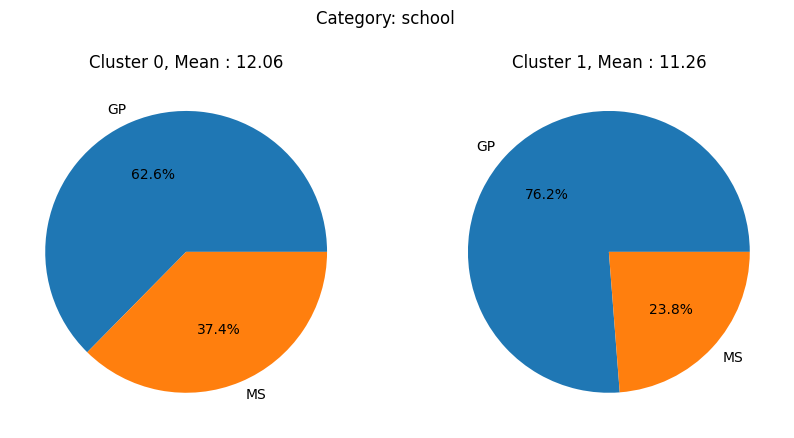

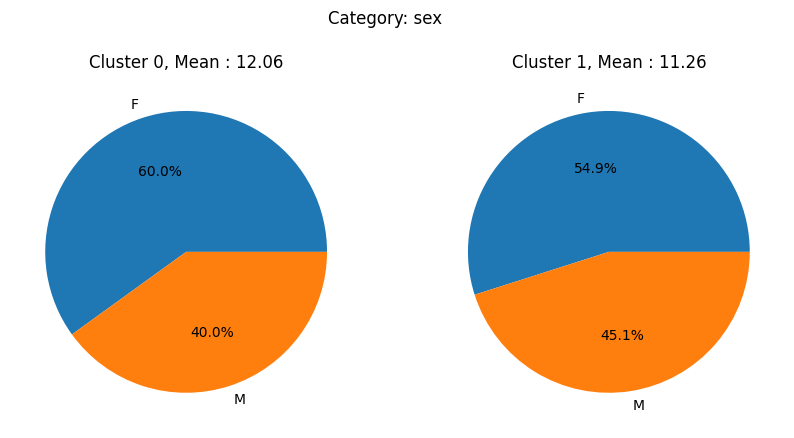

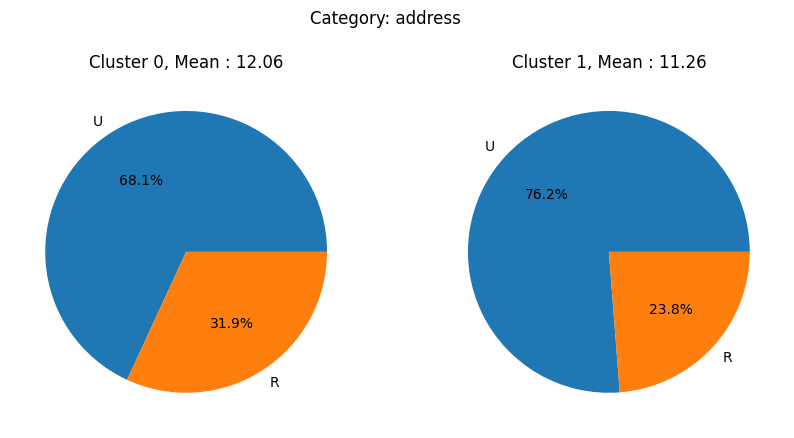

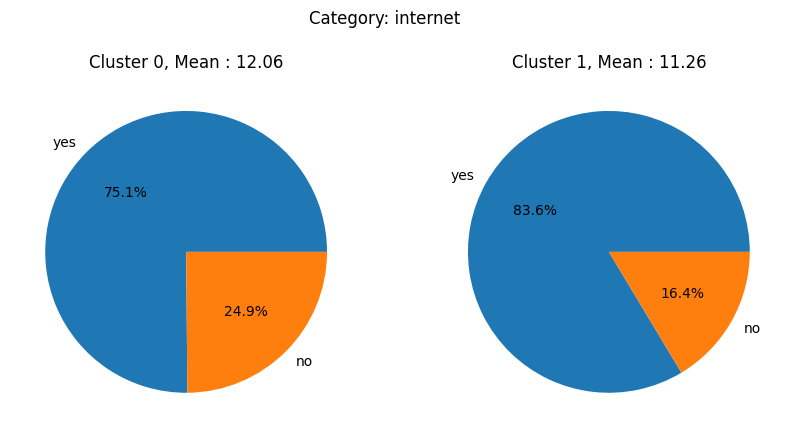

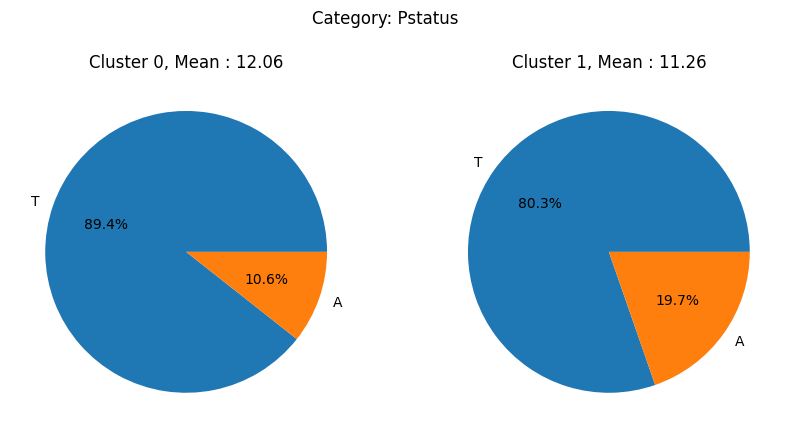

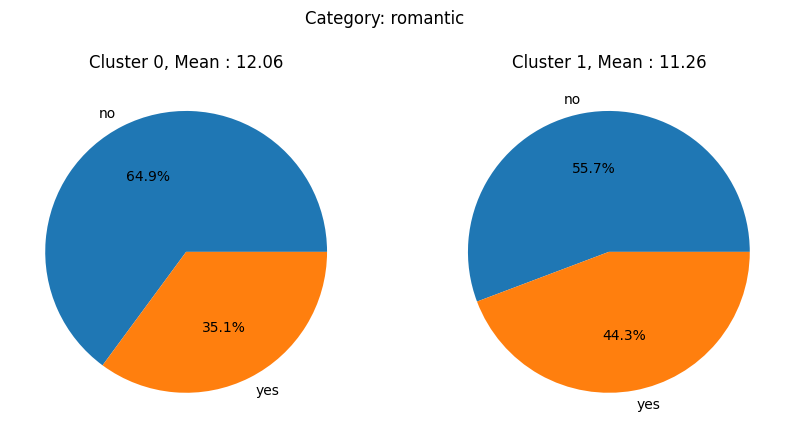

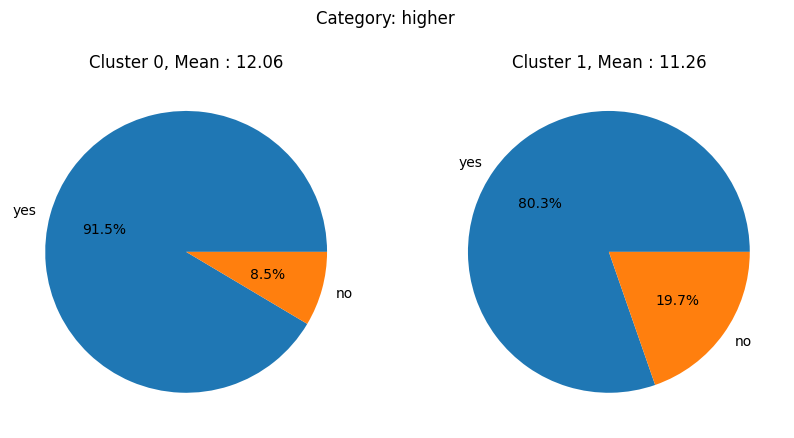

In [9]:
def compareCategory(categoryName : str):
    fig, ax = plt.subplots(1, numClusters, figsize=(10, 5))

    for i in range(0, numClusters):
        category = X[X['cluster'] == i][categoryName].value_counts()
        category = category / category.sum()

        ax[i].pie(category, labels=category.index, autopct='%1.1f%%')
        ax[i].set_title(f"Cluster {i}, Mean : {groupsWiseStats['G3'][i]:.2f}")
    
    fig.suptitle("Category: " + categoryName)
    plt.show()

compareCategory('school')
compareCategory('sex')
compareCategory('address')
compareCategory('internet')
# compareCategory('famsize')
compareCategory('Pstatus')
compareCategory('romantic')
compareCategory('higher')

- **Urban students perform worse than rural students** 
    ![Untitled](https://prod-files-secure.s3.us-west-2.amazonaws.com/bc450a6a-d075-4600-8f11-6d2e2483d511/e8c83c6c-81a4-44c0-929e-b6be0750b656/Untitled.png)
- **Effect of parent status on grades**
    ![Untitled](https://prod-files-secure.s3.us-west-2.amazonaws.com/bc450a6a-d075-4600-8f11-6d2e2483d511/46428c8e-7744-4977-a3dc-80e0376dcbea/Untitled.png)
- **Effect of internet on grades**
    ![Untitled](https://prod-files-secure.s3.us-west-2.amazonaws.com/bc450a6a-d075-4600-8f11-6d2e2483d511/7c4624c3-5445-4573-8113-04766dfdf20a/Untitled.png)
- **Which features are dominant in predicting no. of failures/absences/grades ?**
    use linear regression to predict no. of failures. weights of which features are more prominent than others? - use regularisation for feature selection
- **Effect of romantic relationships on grade: significant?**
    ![Untitled](https://prod-files-secure.s3.us-west-2.amazonaws.com/bc450a6a-d075-4600-8f11-6d2e2483d511/2e417f31-0f47-4d96-bb17-3aac1211fc4a/Untitled.png)  
- **Correlation of grade on higher education choice**
    ![Untitled](https://prod-files-secure.s3.us-west-2.amazonaws.com/bc450a6a-d075-4600-8f11-6d2e2483d511/5769cbf1-a9c2-454a-aafe-7c8f55679d48/Untitled.png)
1. Friedman’s test on G1, G2, G3 (grades taken at 3 different timepoints)
2. Correlation between Fedu (father education), Medu (mother educations), family relations, gout (going out), Dalc (daily alcohol consumption), Walc (weekend alcohol consumption), health (perform factor analysis). All these variables are ordinal.
3. Linear Regression: make 2-3 models, compare them using VIF and choose the best model. Also try combining 2-3 variables and check the performance. Compare results with Bayesian regression.
4. Perform chi square test for independence using contingency table for following pairs:
    1. Attended nursery and want to go for higher studies.
    2. Extra paid classes for coursework and want to go for higher studies.
    3. Educational support from family and want to go for higher studies.
5. log linear analysis to analyze multiple variables. (remaining)
6. Median test for independent samples:
    1. free time (can be split in low, medium and high) after school and grades.
    2. travel time (can be split in low, medium and high) to school and grades.
    3. study time (can be split in low, medium and high) and grades and grades.
7. Difference between grades of students depending on the school (2 types of school in dataset) and type of area (urban or rural)
Basic EDA and normality checks have been performed. Through the results of all these hypotheses we will try to paint a bigger picture about the student's academic life. 
Please suggest any changes/improvements that we should consider

In [10]:
import seaborn as sns

sns.heatmap(allData.corr(), annot=True)

ValueError: could not convert string to float: 'GP'